# Gradients in compression

In [1]:
using NetCDF, PyPlot, BitInformation
using TranscodingStreams, CodecZstd
using Dates, ZfpCompression

In [2]:
ZstdCompressorL10 = ZstdCompressor(level=10)
TranscodingStreams.initialize(ZstdCompressorL10)

ZstdCompressorL22 = ZstdCompressor(level=22)
TranscodingStreams.initialize(ZstdCompressorL22)

In [3]:
path= "/network/aopp/chaos/pred/kloewer/esowc/satellite/viirs_I_20210513_t2342292.nc"
ncfile = NetCDF.open(path)
I04 = ncfile.vars["I04"][2800:6500,500:5500]
start_time = ncfile.vars["I04"].atts["start_time"];

In [4]:
# Information
bi04 = bitinformation(I04)

32-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.15101932717976135
 0.15101932717976135
 0.15009321007652204
 0.6208004959957647
 0.6495172139139991
 ⋮
 0.022551093505074338
 0.02609418976321165
 0.023114394087265844
 0.023231858405827255
 0.0246011882260731
 0.02437129477383726
 0.0243177382558859
 0.02412365655247123
 0.03392860675417908
 0.022427230330280656
 0.022970932774067088
 0.024309716659365876

In [5]:
# filter
bi04filt = [if b > maximum(bi04[25:end]) b else 0.0 end for b in bi04]
p = 0.99
keepbits04 = argmax(cumsum(bi04filt)/sum(bi04filt) .>= p) - 9

9

# Compression

In [6]:
I04r = round(I04,keepbits04);

In [7]:
comp_fac04 = 2*sizeof(I04)/sizeof(transcode(ZstdCompressorL10,copy(reinterpret(UInt8,vec(I04r)))))

13.690892901557902

# Zfp

In [8]:
# precision with log-preprocess
I04x = zfp_compress(log10.(I04),precision=16)
comp_fac_zfp = 2*sizeof(I04)/sizeof(I04x)
I04z = 10.0 .^zfp_decompress(I04x);

In [382]:
# tolerance mode
# I04x = zfp_compress(I04,tol=4.0)
# comp_fac_zfp = 2*sizeof(I04)/sizeof(I04x)
# I04z = zfp_decompress(I04x);

In [9]:
comp_fac_zfp

14.49255354634419

# Gradients / Laplace

In [10]:
function Δ(f::AbstractMatrix{T}) where T
    m,n = size(f)
    Δf = Array{T}(undef,m-2,n-2)
    for j in 2:n-1
        for i in 2:m-1
            fij = f[i,j]
            δx1 = fij - f[i-1,j]
            δx2 = f[i+1,j] - fij
            δy1 = fij - f[i,j-1]
            δy2 = f[i,j+1] - fij
            Δf[i-1,j-1] = (δx2-δx1) + (δy2-δy1)
        end
    end
    return Δf
end

function ∂x(f::AbstractMatrix{T}) where T
    m,n = size(f)
    ∂xf = Array{T}(undef,m-1,n)
    for j in 1:n
        for i in 2:m
            ∂xf[i-1,j] = f[i,j] - f[i-1,j]
        end
    end
    return ∂xf
end

function ∂y(f::AbstractMatrix{T}) where T
    m,n = size(f)
    ∂yf = Array{T}(undef,m,n-1)
    for j in 2:n
        for i in 1:m
            ∂yf[i,j-1] = f[i,j] - f[i,j-1]
        end
    end
    return ∂yf
end

∂y (generic function with 1 method)

In [11]:
# grid spacing is approximately 300m
Δx = 300
Δx² = Δx^2

# apply a conversion to high precision before analysis
ΔI04 = Δ(Float64.(I04)) / Δx²
ΔI04r = Δ(Float64.(I04r)) / Δx²
ΔI04z = Δ(Float64.(I04z)) / Δx²

∂xI04 = ∂x(Float64.(I04)) / Δx * 1000
∂xI04r = ∂x(Float64.(I04r)) / Δx * 1000
∂xI04z = ∂x(Float64.(I04z)) / Δx * 1000;

∂yI04 = ∂y(Float64.(I04)) / Δx * 1000
∂yI04r = ∂y(Float64.(I04r)) / Δx * 1000
∂yI04z = ∂y(Float64.(I04z)) / Δx * 1000;

In [12]:
# length of the gradient vector
∂xyI04 = sqrt.(∂xI04[:,1:end-1].^2 .+ ∂yI04[1:end-1,:].^2)
∂xyI04r = sqrt.(∂xI04r[:,1:end-1].^2 .+ ∂yI04r[1:end-1,:].^2)
∂xyI04z = sqrt.(∂xI04z[:,1:end-1].^2 .+ ∂yI04z[1:end-1,:].^2);

# Plotting

In [13]:
using ColorSchemes, Statistics, StatsBase
cmap = ColorMap(ColorSchemes.roma.colors).reversed()
cmap_div = ColorMap(ColorSchemes.bilbao.colors)

In [14]:
vmin,vmax = quantile(vec(I04),[0.01,0.99])

vmin = 280
vmax = 290

vmin_div = -1 / Δx²
vmax_div = 1 / Δx²

vmin_div = -1e-5
vmax_div = 1e-5

vmin_div = 0
vmax_div = 1 * (1000 / Δx)

interpolation = "nearest"
aspect = "equal"

"equal"

In [15]:
# region
x0,x1 = 1190,1320
y0,y1 = 2820,2910

(2820, 2910)

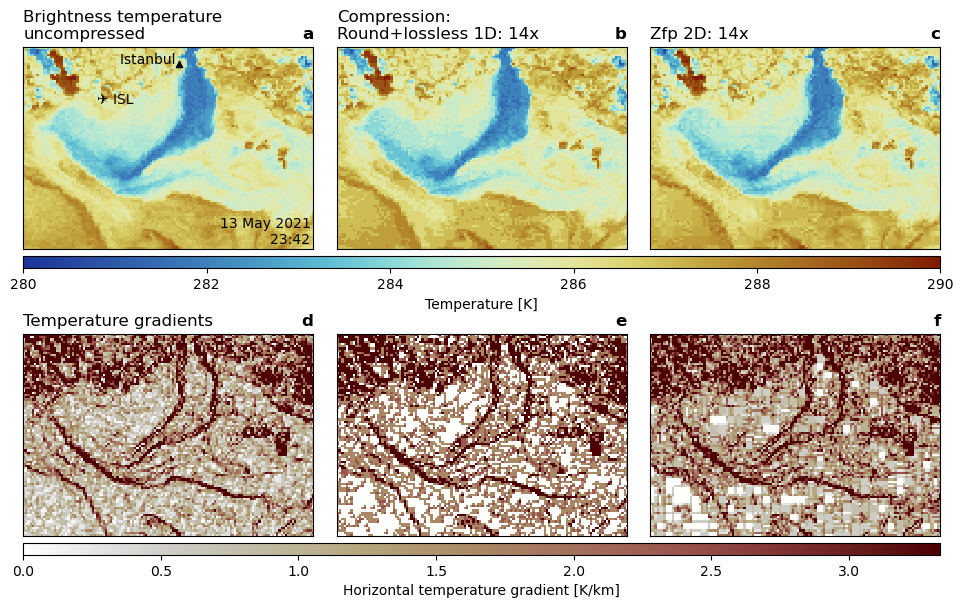

In [16]:
fig,axs = subplots(2,3,sharex=true,sharey=true,figsize=(10,6.1))

tight_layout(rect=[-0.01,0.05,0.98,0.95],w_pad=0.1,h_pad=5)

ax1 = axs[1,1]
ax2 = axs[1,2]
ax3 = axs[1,3]
ax4 = axs[2,1]
ax5 = axs[2,2]
ax6 = axs[2,3]

# ax1 = fig.add_axes(rect=[0.02,0.55,0.27,0.3])
# ax2 = fig.add_axes(rect=[0.32,0.55,0.27,0.3])
# ax3 = fig.add_axes(rect=[0.62,0.55,0.27,0.3])
# ax4 = fig.add_axes(rect=[0.02,0.12,0.27,0.3])
# ax5 = fig.add_axes(rect=[0.32,0.12,0.27,0.3])
# ax6 = fig.add_axes(rect=[0.62,0.12,0.27,0.3])

ax123s = [ax1,ax2,ax3]
ax456s = [ax4,ax5,ax6]

pos1 = ax1.get_position()
pos3 = ax3.get_position()
cax = fig.add_axes([pos1.x0,pos1.y0-0.03,pos3.x1-pos1.x0,0.02])

pos4 = ax4.get_position()
pos6 = ax6.get_position()
cax2 = fig.add_axes([pos4.x0,pos4.y0-0.03,pos6.x1-pos4.x0,0.02])


q = ax1.imshow(I04[x0:x1,y0:y1]';aspect,interpolation,cmap,vmin,vmax)
ax2.imshow(I04r[x0:x1,y0:y1]';aspect,interpolation,cmap,vmin,vmax)
ax3.imshow(I04z[x0:x1,y0:y1]';aspect,interpolation,cmap,vmin,vmax)
cbar = colorbar(q,cax=cax,orientation="horizontal",label="Temperature [K]")

qd = ax4.imshow(∂xyI04[x0:x1,y0:y1]',cmap=cmap_div,vmin=vmin_div,vmax=vmax_div;aspect,interpolation)
ax5.imshow(∂xyI04r[x0:x1,y0:y1]',cmap=cmap_div,vmin=vmin_div,vmax=vmax_div;aspect,interpolation)
ax6.imshow(∂xyI04z[x0:x1,y0:y1]',cmap=cmap_div,vmin=vmin_div,vmax=vmax_div;aspect,interpolation)
cbar2 = colorbar(qd,cax=cax2,orientation="horizontal",label="Horizontal temperature gradient [K/km]")

for (iax,ax) in enumerate(vcat(ax123s,ax456s))
    ax.set_title(string(Char(iax+96)),loc="right",fontweight="bold")
    ax.set_xticks([])
    ax.set_yticks([])
end

ax1.set_title("Brightness temperature\nuncompressed",loc="left")
ax2.set_title("Compression:\nRound+lossless 1D: $(round(Int,comp_fac04))x",loc="left")
ax3.set_title("Zfp 2D: $(round(Int,comp_fac_zfp))x",loc="left")
ax4.set_title("Temperature gradients",loc="left")

ax1.text(0.99,0.01,Dates.format(Dates.Date(start_time[1:10]),"d u yyyy")*
    "\n$(start_time[12:16])",
    transform=ax1.transAxes,color="k",ha="right",va="bottom")

ax1.scatter(70,7,20,"k",marker="^")
# ax1.scatter(40,50,20,"k",marker="^") 
ax1.text(70,7,"Istanbul ",ha="right")
ax1.text(33,25,"✈ ISL")

savefig("brightness_temp_grad.png",dpi=200)
savefig("brightness_temp_grad.pdf")